## IMDB Reviews Sentiment prediction with Deep Learning

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

In [2]:
sentences = ['visit Doreen right now', 'Doreen is hosting a birthday party right now']
tokenizer = Tokenizer(num_words=12, oov_token='<OOV>')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

word_index

{'<OOV>': 1,
 'doreen': 2,
 'right': 3,
 'now': 4,
 'visit': 5,
 'is': 6,
 'hosting': 7,
 'a': 8,
 'birthday': 9,
 'party': 10}

In [3]:
sequences = tokenizer.texts_to_sequences(sentences)
sequences

[[5, 2, 3, 4], [2, 6, 7, 8, 9, 10, 3, 4]]

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=8, padding = 'post')
padded

array([[ 5,  2,  3,  4,  0,  0,  0,  0],
       [ 2,  6,  7,  8,  9, 10,  3,  4]], dtype=int32)

## IMDB dataset Download

In [5]:
import tensorflow_datasets as tfds
import numpy as np

In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVQ4XM/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVQ4XM/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteVVQ4XM/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [7]:
class_names = info.features['label'].names

In [8]:
training_sentences = []
training_labels = []

for text, label in dataset['train']:
  training_sentences.append(text.numpy().decode())
  training_labels.append(label.numpy())

testing_sentences = []
testing_labels = []

for text, label in dataset['test']:
  testing_sentences.append(text.numpy().decode())
  testing_labels.append(label.numpy())

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Text Cleaning

In [9]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-qdo88cbu
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-qdo88cbu
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7602 sha256=ccf23a64bb4a0343be3fd167aa916cfc19e6d0ee683ec14675874649e5f62c31
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3n0e2ia/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [10]:
import preprocess_kgptalkie as ps
import re

In [11]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.cont_exp(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_rt(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [12]:
text = get_clean(training_sentences[0])
text

'this was an absolutely terrible movie do not be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it'

In [13]:
training_sentences = [get_clean(x) for x in training_sentences]
testing_sentences = [get_clean(x) for x in testing_sentences]

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


## Text Length Plot

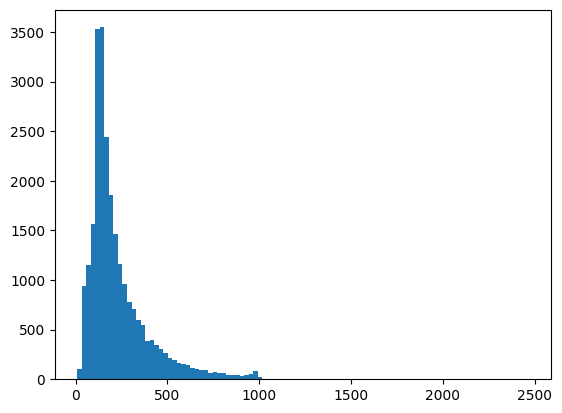

In [14]:
import matplotlib.pyplot as plt

plt.hist([len(x.split(" ")) for x in training_sentences], bins=100)
plt.show()

In [15]:
vocab_size = 50_000
input_length = 1000

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=input_length, padding='post', truncating='post')

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=input_length, padding='post', truncating='post')

In [17]:
vocab_dict = tokenizer.word_index

## Model Building

In [18]:
from keras import Sequential
from keras.layers import Embedding, Dense, Dropout, Conv1D, GlobalAveragePooling1D

In [28]:
embed_dim = 64
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length=input_length))
model.add(Conv1D(64, 3, activation='relu'))
model.add(Conv1D(128, 3, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [44]:
history = model.fit(training_padded, training_labels, epochs=5, validation_data=(testing_padded, testing_labels))

Epoch 1/5
782/782 [==============================] - 18s 23ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.8402 - val_accuracy: 0.8592
Epoch 2/5
782/782 [==============================] - 14s 17ms/step - loss: 0.0150 - accuracy: 0.9954 - val_loss: 0.9873 - val_accuracy: 0.8507
Epoch 3/5
782/782 [==============================] - 13s 17ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 1.1018 - val_accuracy: 0.8523
Epoch 4/5
782/782 [==============================] - 12s 15ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.2954 - val_accuracy: 0.8466
Epoch 5/5
782/782 [==============================] - 13s 17ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 1.1638 - val_accuracy: 0.8536


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          3200000   
                                                                 
 conv1d_2 (Conv1D)           (None, 998, 64)           12352     
                                                                 
 conv1d_3 (Conv1D)           (None, 996, 128)          24704     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

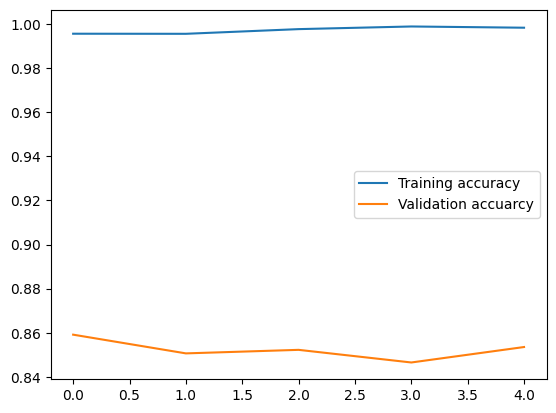

In [46]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuarcy')
plt.legend()
plt.show()

## Model Saving and Loading and Prediction

In [47]:
import pickle

In [48]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
model.save('sentiment_analysis.h5')

In [49]:
from keras.models import load_model
model1 = load_model('sentiment_analysis.h5')
tokenizer1 = pickle.load(open('tokenizer.pkl', 'rb'))

## Testing saved model

In [50]:
news_reviews = [testing_sentences[0]]
news_reviews = [get_clean(x) for x in news_reviews]

new_sequences = tokenizer1.texts_to_sequences(news_reviews)
new_padded = pad_sequences(new_sequences, maxlen = input_length, padding ='post', truncating = 'post')

In [54]:
pred = model1.predict(new_padded)

1/1 [==============================] - 0s 19ms/step


In [55]:
[class_names[int(x[0])] for x in pred > 0.5]

['pos']

In [61]:
news_reviews = ["this movie wasn't interesting at all. i watched it and slept"]
news_reviews = [get_clean(x) for x in news_reviews]

new_sequences = tokenizer1.texts_to_sequences(news_reviews)
new_padded = pad_sequences(new_sequences, maxlen = input_length, padding ='post', truncating = 'post')

In [62]:
 pred = model1.predict(new_padded)

1/1 [==============================] - 0s 18ms/step


In [63]:
[class_names[int(x[0])] for x in pred > 0.5]

['neg']